# XGBoost Classification and Feature Importance

## Overview
This notebook applies an XGBoost classifier to the processed fluorescence trace dataset to distinguish between experimental conditions (e.g., time_0 vs deletion of time_0). It evaluates model performance using multiple metrics and visualizes both the confusion matrix and the feature importance ranking. This step connects extracted fluorescence features to machine learning classification and interpretability.

The notebook performs the following steps:

1. **Data Loading**  
   - Load the feature dataset:  
     `all_traces_norm_train_val.tsv`  
     `all_traces_norm_imputation_train_val.tsv`
   - Both datasets are derived from the Stratified-Group-Kfold train and test split provided in the `data.py` script created by the `create_test_set`
   - Create the output folder `Feature_Importance/` for storing figures and results.

2. **Feature Preparation**  
   - Separate labels and features:  
     - `y`: class labels (strain or condition).  
     - `X`: numeric features representing fluorescence characteristics.  
   - Dynamically map categorical labels to integer IDs for model training.

3. **Model Training and Evaluation**  
   - Split data into training and validation subsets (`test_size=0.2` (80/20 Train/Test ratio), `random_state=42`).  
   - Train an **XGBoost (XGBClassifier)** model.  
   - Evaluate performance using:  
     - Accuracy  
     - Confusion matrix  
     - Classification report (precision, recall, F1-score)  
     - Matthews correlation coefficient (MCC)

4. **Visualization**  
   - Generate and save:  
     - `confusion_matrix.png` — visualizes model prediction accuracy per class.  
     - `feature_importance.png` — displays ranked feature contributions based on the trained XGBoost model.  

## Outputs
All figures and results are saved in the `Feature_Importance/` directory.

- **Plots:**  
  - `confusion_matrix.png`: classification performance visualization.  
  - `feature_importance.png`: most important features driving model predictions.

## Usage
1. Place the file `all_traces_norm_train_val.tsv` and `all_traces_norm_imputation_train_val.tsv` in the same directory as this notebook.  
2. Run the notebook cells in sequence.  
3. Generated figures and metrics will be saved automatically in the `Feature_Importance/` folder.

## Manually Set Values / Parameters
- Cell 4 (line 5): Adjust `test_size` (default = 0.2) for train/validation split ratio.  
- Cell 4: Change `random_state` seed for reproducibility control.  

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, matthews_corrcoef)

In [2]:
# Create folder in which all figures and files are being saved
os.makedirs('Feature_Importance', exist_ok=True)

In [3]:
df = pd.read_csv("all_traces_norm_train_val.tsv", sep="\t")

In [4]:
def xgb_analysis(
    df: pd.DataFrame,
    dateiname_conf="confusion_matrix.png",
    dateiname_feat="feature_importance.png",
    test_size=0.2,
    random_state=42
):
    """
    Train and evaluate an XGBoost classifier, then save and show
    the confusion matrix and feature importance plots.
    """

    # Separate features and labels
    X = df.iloc[:, 3:].values
    y_raw = df.iloc[:, 0]

    # Dynamic label mapping
    label_map = {label: idx for idx, label in enumerate(y_raw.unique())}
    y = y_raw.map(label_map).values

    print("Label mapping:", label_map)
    print("Mapped class labels:", np.unique(y, return_counts=True))

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Train XGBoost classifier
    model = XGBClassifier(eval_metric='logloss', random_state=random_state)
    model.fit(X_train, y_train)

    # Predictions & Metrics
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    print(f"\nAccuracy: {acc:.4f}")
    print(f"MCC: {mcc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(
    cm, annot=True, fmt=".2f", cmap="Blues",
    xticklabels=label_map.keys(), yticklabels=label_map.keys(),
    cbar_kws={'label': 'Proportion'}
    )
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.title("Confusion Matrix", fontsize=14)
    plt.tight_layout()
    plt.savefig(dateiname_conf, dpi=300, bbox_inches='tight')
    plt.show()

    # Feature Importance
    importance_scores = model.feature_importances_
    feature_names = df.columns[3:]
    colors = plt.cm.viridis(importance_scores / max(importance_scores))

    plt.figure(figsize=(12, 6))
    plt.bar(feature_names, importance_scores, color=colors)
    plt.xticks(rotation=90)
    plt.xlabel("Features", fontsize=12)
    plt.ylabel("Importance Score", fontsize=12)
    plt.title("XGBoost Feature Importances", fontsize=14)
    plt.margins(x=0)  # remove white space at plot edges
    plt.tight_layout(pad=0)
    plt.savefig(dateiname_feat, dpi=300, bbox_inches='tight')
    plt.show()

    # Return useful outputs
    return {
        "model": model,
        "label_map": label_map,
        "accuracy": acc,
        "mcc": mcc,
        "y_true": y_test,
        "y_pred": y_pred
    }

Label mapping: {'PR8': 0, 'X31': 1}
Mapped class labels: (array([0, 1]), array([2826, 1502]))

Accuracy: 0.6547
MCC: 0.1677

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.85      0.76       565
           1       0.51      0.30      0.37       301

    accuracy                           0.65       866
   macro avg       0.60      0.57      0.57       866
weighted avg       0.63      0.65      0.63       866



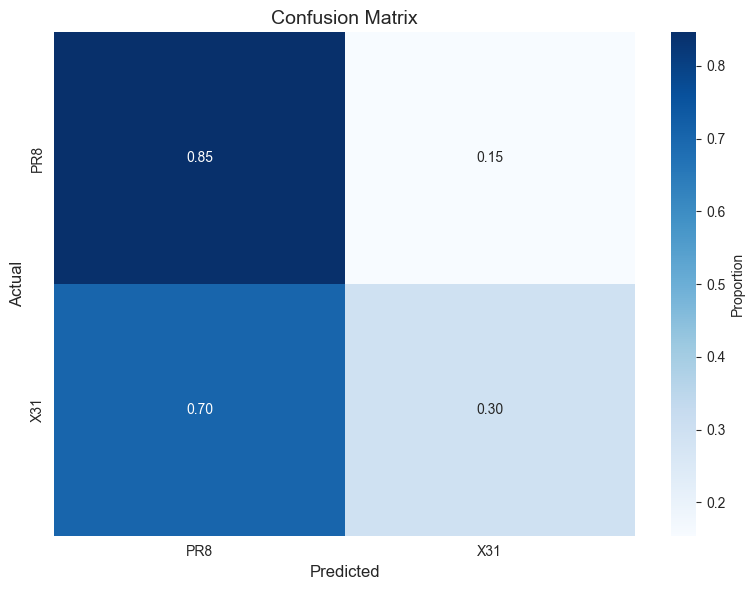

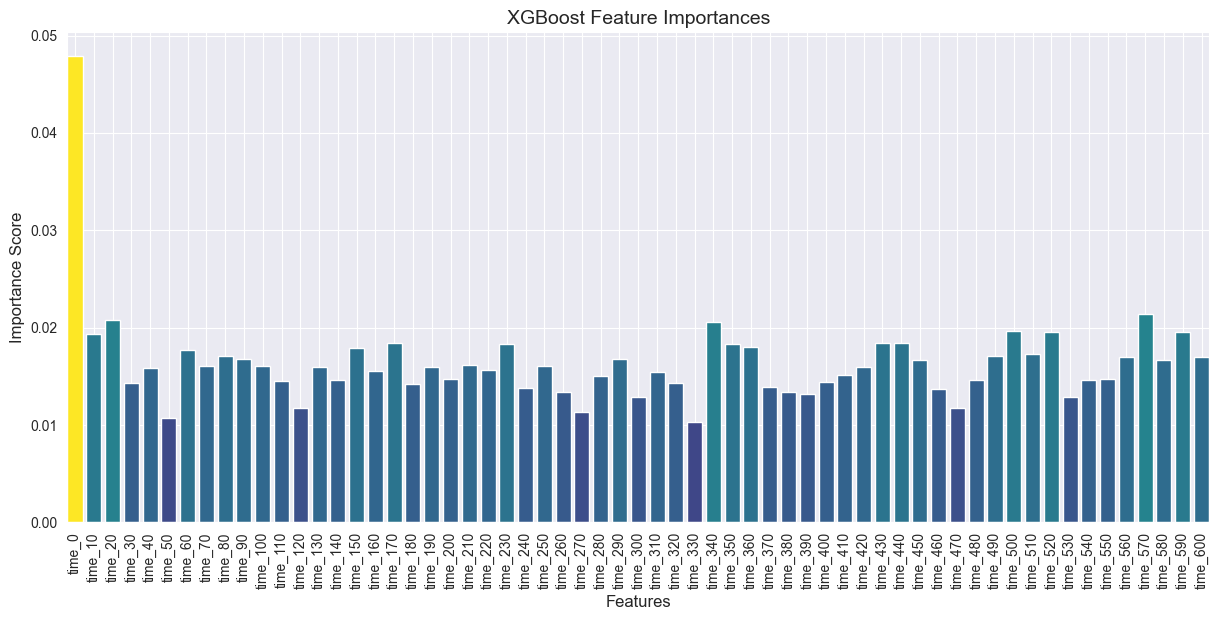

In [5]:
# Call xgb_analysis function
results = xgb_analysis(df,
                       dateiname_conf="Feature_Importance/confusion_matrix_norm.png",
                       dateiname_feat="Feature_Importance/feat_importance_norm.png")

In [6]:
# Load second dataframe for comparison
df1 = pd.read_csv("all_traces_norm_imputation_train_val.tsv", sep="\t")

Label mapping: {'PR8': 0, 'X31': 1}
Mapped class labels: (array([0, 1]), array([2826, 1502]))

Accuracy: 0.6247
MCC: 0.0789

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.84      0.74       565
           1       0.43      0.23      0.30       301

    accuracy                           0.62       866
   macro avg       0.55      0.53      0.52       866
weighted avg       0.59      0.62      0.59       866



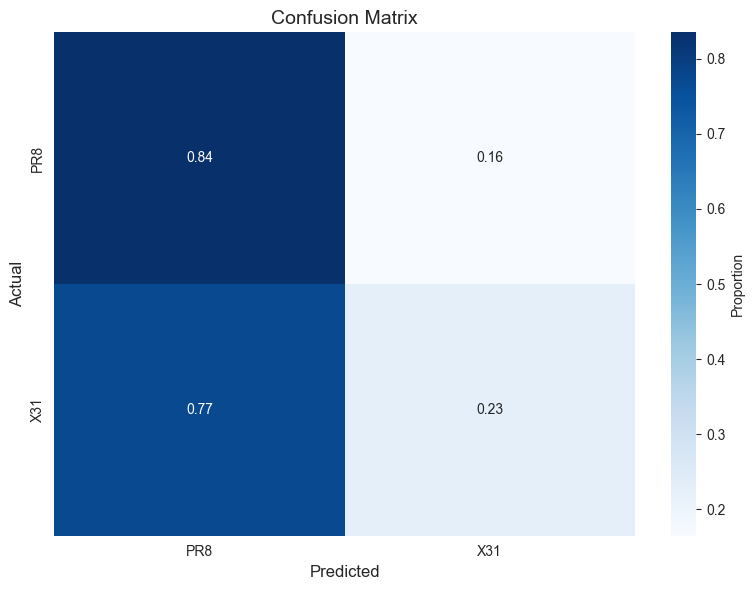

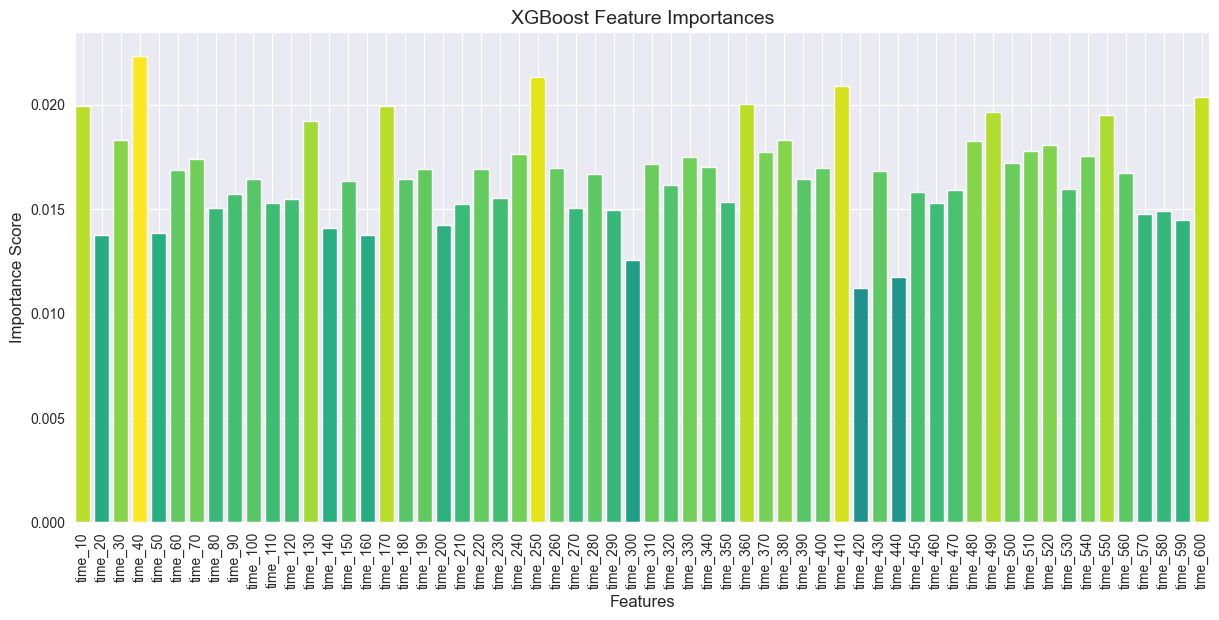

In [7]:
# Call xgb_analysis function
results = xgb_analysis(df1,
                       dateiname_conf="Feature_Importance/confusion_matrix_norm_imp.png",
                       dateiname_feat="Feature_Importance/feat_importance_norm_imp.png")